# **AA1 Project** 

## Modeling delays in the air

In order to predict whether a flight is likely to be delayed or not, create a ML model that will make predictions with that aim. 

First of all. Let's observe our data set and some first insights. 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter

In [10]:
airports = pd.read_csv('airports.csv')

In [11]:
flights = pd.read_csv('flights.csv')
flights = flights.sample(frac=0.005, random_state=42)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_14556/1383576060.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


As we can se with the `describe` method, we can observe the range where each feature takes values at more or less. It is also interesting to observe the histograms of the different columns to see how each feature is distributed more or less, to get an intuition of our data. 

In [12]:
flights.describe()
airports.describe()

,LATITUDE,LONGITUDE
count,319.000000,319.000000
mean,38.981244,-98.378964
std,8.616736,21.523492
min,13.483450,-176.646030
25%,33.652040,-110.839385
50%,39.297610,-93.403070
75%,43.154675,-82.722995
max,71.285450,-64.798560


array([[<AxesSubplot: title={'center': 'YEAR'}>,
        <AxesSubplot: title={'center': 'MONTH'}>,
        <AxesSubplot: title={'center': 'DAY'}>,
        <AxesSubplot: title={'center': 'DAY_OF_WEEK'}>,
        <AxesSubplot: title={'center': 'FLIGHT_NUMBER'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_DEPARTURE'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_TIME'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>,
        <AxesSubplot: title={'center': 'WHEELS_OFF'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'ELAPSED_TIME'}>,
        <AxesSubplot: title={'center': 'AIR_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'WHEELS_ON'}>],
       [<AxesSubplot: title={'center': 'TAXI_IN'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_ARRIVAL'}>,
        <AxesSubplot: title={'center': 'ARRIVAL_TIME'}>

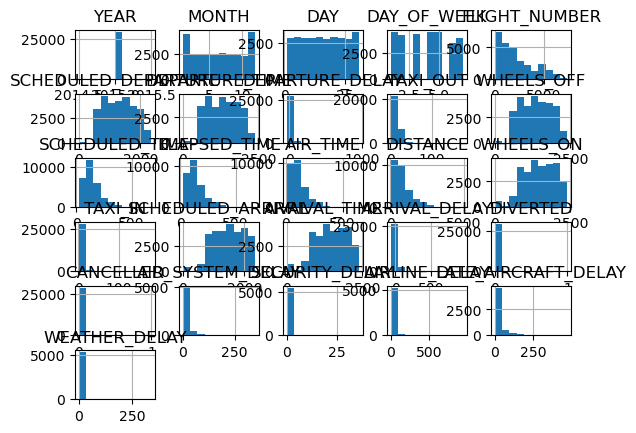

In [13]:
flights.hist()

Based on the results of the histograms, we can appreciate that some of the variables in our dataset present variables where the data appears to be quite concentrated and this could be explained by the presence of large outliers. Some other variables seem to be more uniformally distributed. However, the nature of the distribution that describes the data in our variables shouldn't worry ourselve to much right now as many data processment will be done (including gaussianization of the continuos variables and hot encoding of the categorical ones) before trainging and testing a model.

## 1. Data cleaning
### Nextly we will portray the schedule that we are going to follow. 
1. Check for duplicates: Check for and remove any duplicate rows in our dataset.

2. Handle missing data: Identify any missing data and decide how to handle it. We will either remove the rows or fill in the missing data.

3. Check for inconsistent data: Check for any inconsistent or erroneous data, such as values that are out of range or inconsistent with other data in the same row.

4. Handle categorical data: If you have categorical data, decide how to handle it. One common approach is to use one-hot encoding.

5. Normalize data: Normalize the data so that the features have similar ranges. This will prevent features with large ranges from dominating the model.

6. Feature selection: Select the most relevant features for your model. You can use various techniques such as correlation analysis or principal component analysis (PCA).

7. Train-test split: Finally, split your data into training and testing sets to evaluate the performance of your machine learning model.

### 1.1 Check for duplicates
We firstly see that there are no duplicate samples with the following piece of code.


In [14]:
# Check for duplicates
duplicates = flights.duplicated()

# Print the duplicate rows
len(flights[duplicates])

0

### 1.2 Handle missing data
In this section we have a bunch of different possibilities in order to approach the problem of missing data. 
1. Remove missing data: if the quantity of missing data is not that significative, maybe it is a good option to consider removing all those samples that contain `NaN` values since the subset of samples that is going to be deleted may not be significant while training the model. 



In [15]:
# Count the number of NaN values in each column
nan_counts = flights.isna().sum()
# Print the results
print(nan_counts)

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER               71
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME           403
DEPARTURE_DELAY          403
TAXI_OUT                 422
WHEELS_OFF               422
SCHEDULED_TIME             0
ELAPSED_TIME             488
AIR_TIME                 488
DISTANCE                   0
WHEELS_ON                436
TAXI_IN                  436
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME             436
ARRIVAL_DELAY            488
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON    28669
AIR_SYSTEM_DELAY       23660
SECURITY_DELAY         23660
AIRLINE_DELAY          23660
LATE_AIRCRAFT_DELAY    23660
WEATHER_DELAY          23660
dtype: int64


From the previous output we see that the last 6 features are almost useless since the majority of the samples do not have any information of those, therefore we are going to `drop`. A part from that, we also need to delete columns that regard information that is not going to be available (a posteriori information from the flight) such as information of the time elapsed during time

In [16]:
cols_of_interest = ['ARRIVAL_DELAY','MONTH', 'DAY' ,'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE']
flights = flights[cols_of_interest]

In [17]:
flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,28607.000000,29095.000000,29095.000000,29095.000000,29095.000000,28692.000000,28692.000000,28673.000000,28673.000000,29095.000000,29095.000000
mean,4.125074,6.520571,15.709538,3.898917,1490.800997,1331.679109,9.107730,16.019182,1355.058417,142.040247,824.066541
std,36.711052,3.406649,8.795661,1.979250,505.830048,496.164523,34.383944,8.775297,497.142502,75.478949,609.112340
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,1.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1108.000000,919.000000,-5.000000,11.000000,934.000000,86.000000,373.000000
50%,-5.000000,7.000000,16.000000,4.000000,1515.000000,1327.000000,-2.000000,14.000000,1340.000000,123.000000,647.000000
75%,8.000000,9.000000,23.000000,6.000000,1914.000000,1737.000000,8.000000,19.000000,1752.000000,174.000000,1068.000000
max,947.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,965.000000,177.000000,2400.000000,680.000000,4983.000000


Once we've deleted those columns we can say that **maybe** and only **maybe** taking into account that we have more than 5M samples, deleting the other samples that contain at least one `NaN` value, may be reasonable. 

**CHECK WHETHER THIS IS REASONABLE**

In [18]:
l_bef = len(flights)
flights = flights.dropna(how='any')
l_aft = len(flights)
print(l_bef, l_aft)


29095 28607


We pass from $5819079$ to $5714008$ samples. In other words, we keep the $98.2\%$ of the samples, so it may be a good option to work with these new subset of samples that still contain a vast quantity of information.   

### 1.3 Check for inconsistent data
In order to do so, we firstly observe an overview of our data. 


In [19]:
flights.describe()



,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000
mean,4.125074,6.538749,15.705946,3.905058,1489.867969,1331.545531,9.056455,16.016185,1354.966896,142.182962,825.826196
std,36.711052,3.396849,8.784525,1.976671,506.125155,496.250371,34.249311,8.776067,497.180865,75.530747,609.699309
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,1.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1108.000000,919.000000,-5.000000,11.000000,934.000000,86.000000,373.000000
50%,-5.000000,7.000000,16.000000,4.000000,1515.000000,1327.000000,-2.000000,14.000000,1340.000000,123.000000,649.000000
75%,8.000000,9.000000,23.000000,6.000000,1914.000000,1737.000000,8.000000,19.000000,1752.000000,174.000000,1069.000000
max,947.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,965.000000,177.000000,2400.000000,680.000000,4983.000000


And we will plot a few histograms of the variables in our dataset to get a deeper understanding of their nature. First of all we are going to implement a function that is going to allow us to plot the histogram and personalize a few parameters such as the title, labels for the axis and the options to apply logarithms to any of the axis.

In [20]:
def plot_histogram_of_column(data, title, x_title, y_title, x_log, y_log):
    # Assign default title if none is provided
    if not title:
        title = "Histogram"

    # Assign default title to x axis if none is provided
    if not x_title:
        x_title = "Value"
    
    # Assing default title to y axis if none is provided
    if not y_title:
        y_title = "Count"
    
    # Apply logarithm to x axis if required
    if x_log:
        # Set up histogram with logarithmic x-axis
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data, bins=10**np.linspace(np.log10(0.1), np.log10(data.max()), 50))

        # Set x-axis to logarithmic scale
        ax.set_xscale('log')

        # Add "log" to x axis title
        x_title = "Log " + x_title
    else:
        # Create plot with histogram of DAY column
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data)


    # Apply logarithm to y-axis if required
    if y_log:
        ax.set_yscale('log')

        # Add "log" to y axis title
        y_title = "Log " + y_title
    
    # Add labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Show plot
    plt.show()

Now that we have created a function that allows us to easily plot any column from the dataset that we are interested in, we will start by studying the nature of the columns that refer to delays on the flights

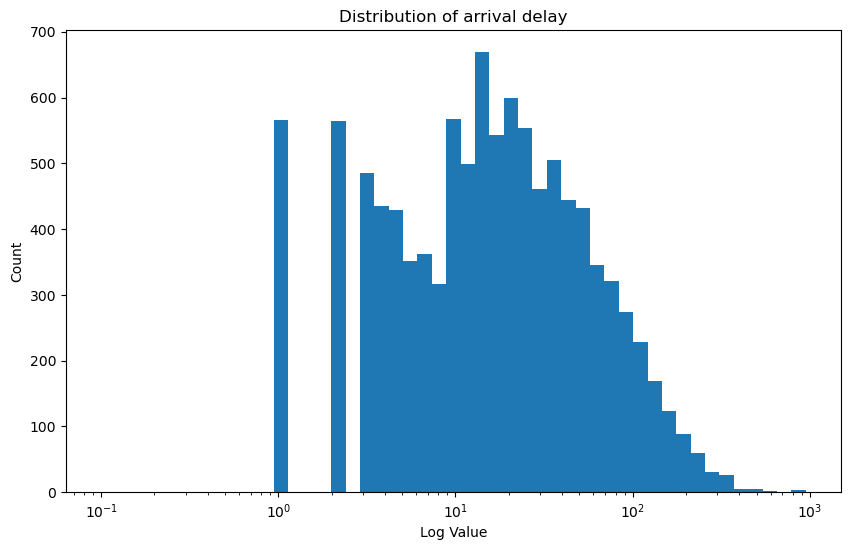

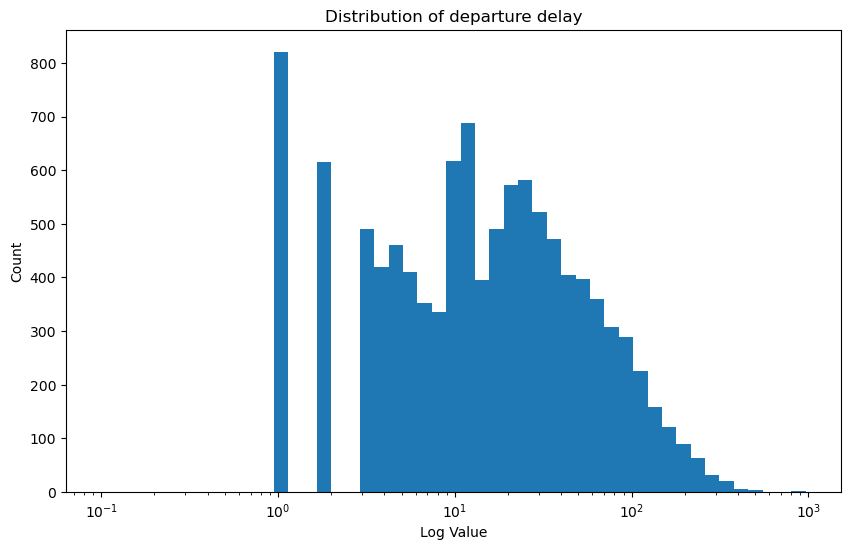

In [21]:
# Plot of the arrival_delay column
plot_histogram_of_column(flights["ARRIVAL_DELAY"], "Distribution of arrival delay", None, None, True, False)

# Histogram of DEPARTURE_DELAY column
plot_histogram_of_column(flights["DEPARTURE_DELAY"], "Distribution of departure delay", None, None, True, False)

It can be seen that both histograms share a similar shape, which means that these two variables are strongly correlated. However, we expected to get this result since those flights that suffer departure with any form of delay are extremely likely to also arrive with a similar delay.

Another interesting result extracted from the data is that there are quite a lot of flights that depart before their scheduled departure time. Moreover, if we compare closely both histograms, we will notice that the amount of flights that arrive before their arrival time is smaller than the number of flights that departure ahead of their departure time.

Next we are going to analyse how the variables containing data related with the date of the flight are distributed.

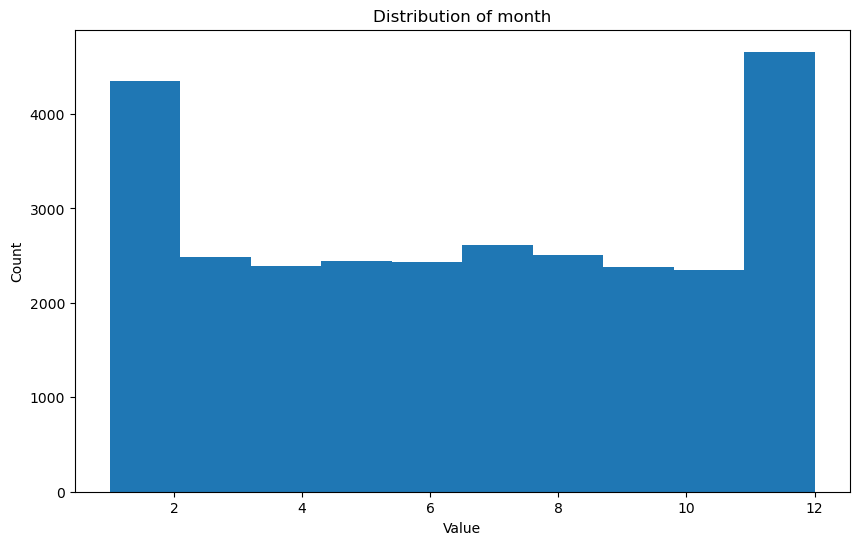

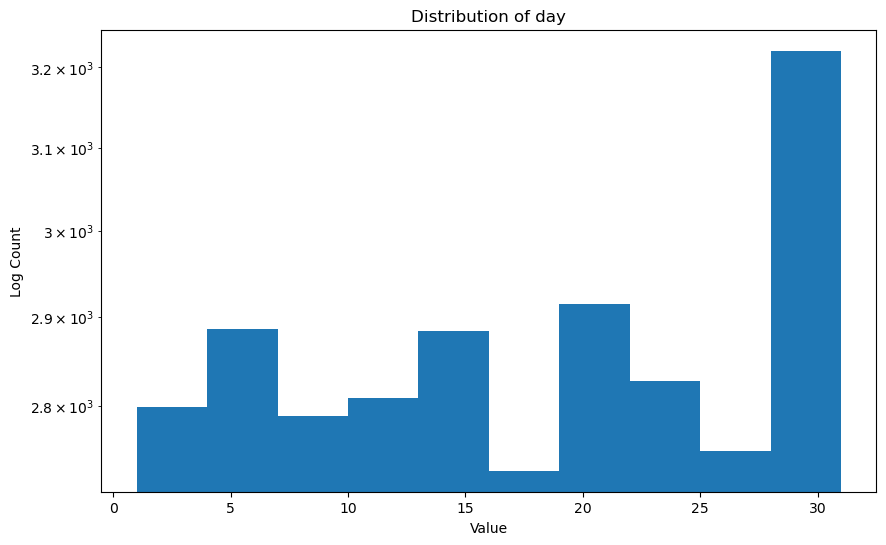

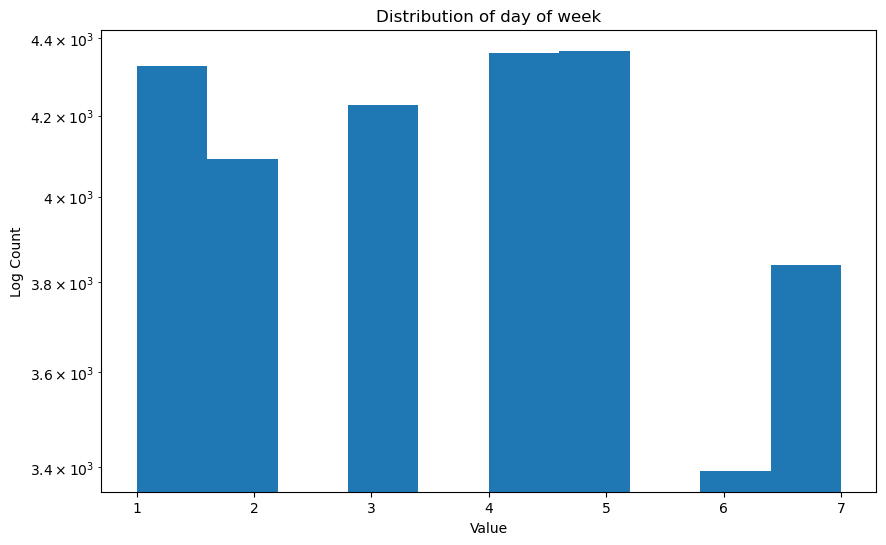

In [22]:
plot_histogram_of_column(flights["MONTH"], "Distribution of month", None, None, False, False)

# Create plot with histogram of DAY column
plot_histogram_of_column(flights["DAY"], "Distribution of day", None, None, False, True)

# Histogram of DAY_OF_WEEK colum
plot_histogram_of_column(flights["DAY_OF_WEEK"], "Distribution of day of week", None, None, False, True)



And, finally, we'll plot some other columns that could be interesting to analyse.

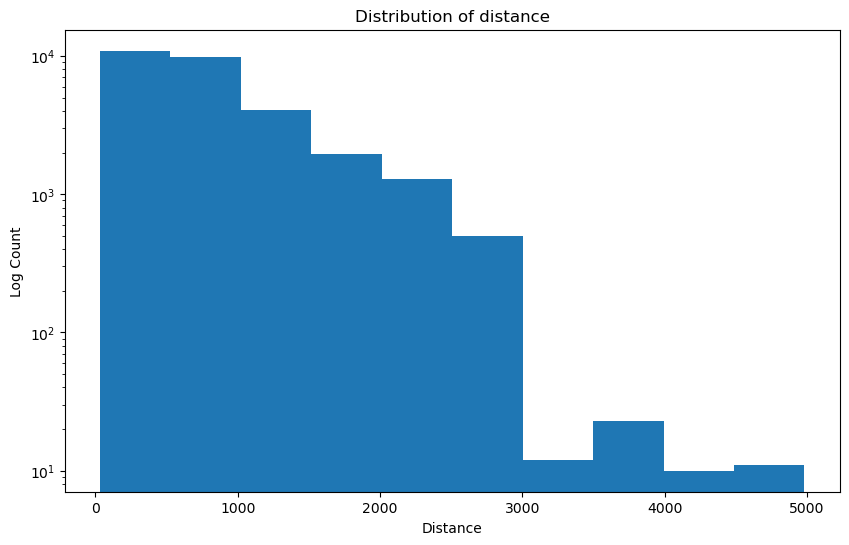

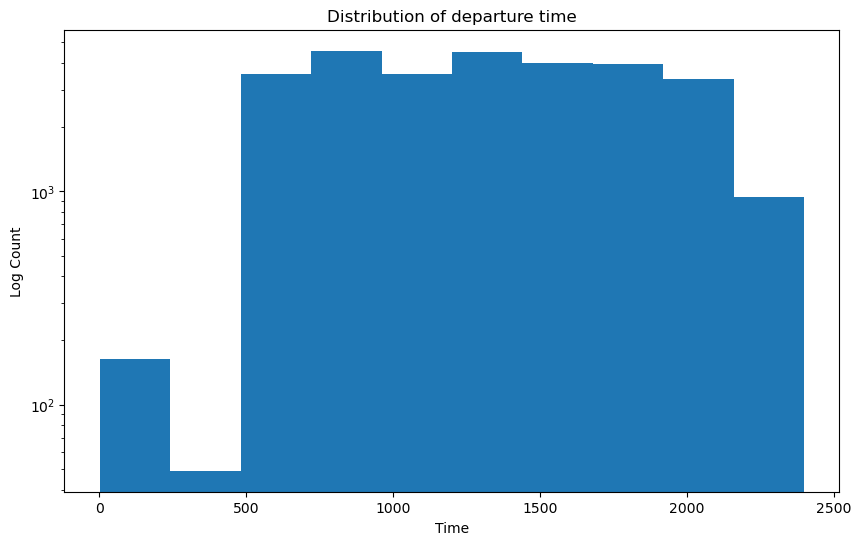

In [23]:
plot_histogram_of_column(flights["DISTANCE"], "Distribution of distance", "Distance", None, False, True)

plot_histogram_of_column(flights["DEPARTURE_TIME"], "Distribution of departure time", "Time", None, False, True)

Looking at the distance plot, we observe that the distance of the vast majority of flights range between a few hundred and a three thousand miles. The longest flights in the dataset are around 5000 miles. 

On the other hand, looking at the distribution of the departure time variabel, we see that fligh departure are almos uniformly distributed from 6 am to 8 pm. From 9 pm to 5 am, a much smaller number of departure take place.

In [24]:
print(flights["DESTINATION_AIRPORT"].unique())

['DTW' 'SEA' 'DAL' 'HNL' 'ATL' 'TPA' 'PHX' 'LAX' 11292 'BWI' 'SJU' 'SMF'
 'BNA' 'CLT' 'CAE' 'MSP' 'DFW' 'SAN' 'OGG' 'OAK' 14107 'DCA' 'BOS' 'HRL'
 'MCI' 'SNA' 'ORD' 'MIA' 'RNO' 12451 'SFO' 'SAT' 'IAH' 'SLC' 'LAS' 'DEN'
 'PIT' 'ACV' 'DRO' 'GSP' 'RSW' 'ITO' 12266 'LSE' 'OKC' 'DAY' 'EWR' 10299
 'PHL' 'HOU' 11298 'MFE' 'FLL' 'MSY' 'IND' 'BZN' 'PSP' 'ASE' 'MEM' 'RDU'
 'SBA' 15016 'SJC' 11066 'JAC' 'MCO' 'ROC' 11697 'BOI' 'CLE' 13830 10257
 14908 'SDF' 12278 'MKE' 'JFK' 12889 10397 'RDM' 13851 'BRW' 'ALB' 'OMA'
 'CRP' 'RIC' 'DHN' 11618 'BUR' 'CVG' 'MDW' 14893 'JAX' 13485 'ABQ' 12402
 'CMH' 12264 10721 'PVD' 11433 'KTN' 10154 'LGA' 'PDX' 'LRD' 'SYR' 'PBI'
 'ANC' 'BUF' 'RST' 'TUL' 'TUS' 'STL' 'TLH' 'BDL' 'AUS' 'MSN' 11278 13204
 14771 'CHS' '13232' 'DSM' '12478' 14869 'AMA' 'LGB' 'GRR' 'IAD' 10874
 'ONT' 'LIH' 'PIB' 15370 10980 13303 'GSO' 'MYR' 12478 11057 'BIS' 13930
 'CDV' 14679 10713 'MOB' 14576 'KOA' 'TRI' 'CHO' 14843 'LEX' 11447 'MGM'
 15919 14057 'ELP' 'IDA' 'MVY' 'EWN' 13487 10140 'COS

In [25]:
flights.loc[flights['WHEELS_OFF'] == 2400, 'WHEELS_OFF'] = 2359
flights.loc[flights['DEPARTURE_TIME'] == 2400, 'DEPARTURE_TIME'] = 2359



flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000,28607.000000
mean,4.125074,6.538749,15.705946,3.905058,1489.867969,1331.544098,9.056455,16.016185,1354.964030,142.182962,825.826196
std,36.711052,3.396849,8.784525,1.976671,506.125155,496.247344,34.249311,8.776067,497.174958,75.530747,609.699309
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,1.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1108.000000,919.000000,-5.000000,11.000000,934.000000,86.000000,373.000000
50%,-5.000000,7.000000,16.000000,4.000000,1515.000000,1327.000000,-2.000000,14.000000,1340.000000,123.000000,649.000000
75%,8.000000,9.000000,23.000000,6.000000,1914.000000,1737.000000,8.000000,19.000000,1752.000000,174.000000,1069.000000
max,947.000000,12.000000,31.000000,7.000000,2359.000000,2359.000000,965.000000,177.000000,2359.000000,680.000000,4983.000000


As we can infer from the output of the `decribe()` method, there are no values that are out of range or are non-sense in comparison with other values of the same column. 

In [26]:
# Delete all of the rows that contain integer values
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: isinstance(x, int))]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: isinstance(x, int))]


In [27]:
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: str(x).isnumeric())]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: str(x).isnumeric())]

### 1.4 Handle categorical data


We are going to start by looking at our columns to determine what type of data each one of them contains.


In [28]:
#Check nature of the columns 
for col in flights.columns:
  print(col, flights[col].dtype)

ARRIVAL_DELAY float64
MONTH int64
DAY int64
DAY_OF_WEEK int64
AIRLINE object
ORIGIN_AIRPORT object
DESTINATION_AIRPORT object
SCHEDULED_ARRIVAL int64
DEPARTURE_TIME float64
DEPARTURE_DELAY float64
TAXI_OUT float64
WHEELS_OFF float64
SCHEDULED_TIME float64
DISTANCE int64


Now that we have an idea of the nature of each column we must determine which columns we are going to modify. Those columns are going to be the ones containing categorical variables. We are going to modify:
- Month
- Arrival_delay
- Day
- Day_of_week
- Origin_airport
- Destination_airport

The next thing we want to do after observing the types of every feature is to transform some variables to categorical

#### Month column

The transformation we have chosen for the MONTH column is grouping the month by quarters. This will allow us to reduce the number of categories from 12 to 3. 

Additionally, when dividing the year in quarters we get a partition that closely matches the different travel seasons. Summer season matches almost perfectly with the second quarter while the first and third quarter match with winter season.

In [29]:
# MONTH treatment: group months in quarters
flights['Q_YEAR'] = flights['MONTH'].apply(lambda x: (x-1)//4 + 1)

#### Arrival_delay column

Another column which's data we need to process is the ARRIVAL_DELAY column. This column is the one we want to predict and the aim of our model is to be able to predict if a flight will arrive to its destination with some type of delay. Therefore, we want to convert this column into a column with binary values.

We will create a new column in our dataset (i.e. DELAYED) which will have a 1 if the flight is delayed and 0 otherwise.

In [30]:
# DELAY TREATMENT
flights['DELAYED'] = flights['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)

#### Day column

The DAY column has values that range from 1 to 31, which it's unfeasible to work with. We have decided to divide the month in two fortnights and classify each day with the value of the fortnight they belong to. 
- From days 1 - 15 they will belong to the first fortnight. They will have a value of 1.
- From days 15 - 31 they will belong to the second fortnight. The will have a value of 2.

In [31]:
# DAY treatment 

flights['FORTNIGHT'] = pd.cut(flights['DAY'], bins=[0, 15, 31], labels=[1, 2], include_lowest=True)


We believe that this is an appropiate transformation because, usually, people earn they salaries at the end of the month. Therefore, people will have more money available during the first fortnight and this could mean that the number of passengers increase causing to be more flights during the first fortnight. 


#### Day_of_week column

The same arguments we used for the DAY column apply to DAY_OF_WEEK. The values in this column range from 1 (i.e.: Monday) to 7 (i.e.: Sunday). Instead of working with each of this values, we are going to separate them into working days and weekends.

In [32]:
# DAY_OF_WEEK 1 is in-week days, 2 is weekend

flights['WEEK_INFO'] = pd.cut(flights['DAY_OF_WEEK'], bins=[1, 5, 7], labels=[1, 2], include_lowest=True)


#### Airline column

We are now going to treat the AIRLINES column. Originally, our dataframe had around 15 different airlines and we considered that it was going to be unfeasible to work with all of them. Therefore, we have decided to divide them intro three major groups:
- Major airlines
- Low cost airlines
- Regional airlines

We believe that this is a valid division because the nature of the airline could possibly affect the amount of delayed flights they have. 

In [33]:
# AIRLINE

# Define the airlines categories
major_airlines = ['DL', 'AA', 'UA', 'US', 'AS']
low_cost_airlines = ['WN', 'NK', 'F9', 'B6', 'VX']
regional_airlines = ['EV', 'OO', 'MQ', 'HA']

# create a new column with the airline category
flights['AC'] = 'Other'
flights.loc[flights['AIRLINE'].isin(major_airlines), 'AC'] = 'Major'
flights.loc[flights['AIRLINE'].isin(low_cost_airlines), 'AC'] = 'Low-Cost'
flights.loc[flights['AIRLINE'].isin(regional_airlines), 'AC'] = 'Regional'

#### Origin_airport column

In the original dataset there are over 300 different airports. Although it would be great to be able to keep all of them as individual categories, we have also considered it unfeasible. So, in order to reduce the number of categories, we are going to divide the USA territory in four quadrants:
- Upper left
- Upper right
- Bottom right
- Bottom left

However, before being able to classify the airports as we just mentioned, we first need to get its coordinates. This can be achieved by extractinc the necessary data (i.e. longitude and latitude) from the *airports* dataset

In [34]:
# Change the index of the dataset to the IATA_CODE (code that identifies each airport)
airports = airports.set_index('IATA_CODE')

In [35]:
# Add LONGITUDE_O column to each row in flights with the longitude of the origin airport
flights['LONGITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])

# Add LATITUDE_O column to each row in flights with the latitude of the origin airport
flights['LATITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])

However, we have detected that some rows have a *NaN* value in either their longitude or latitude. Since this happens rarely, we can delete those columns without loosing to many rows. 

In [36]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_O"].isna() == False
count_false = sum(counter)
print(count_false/len(flights["LONGITUDE_O"]))
flights = flights.dropna(how='any')


0.9993145207357478


Once we have removed al conflictive rows, we can proceed with the classification of the airports by its location.

In [37]:
# Create empty column with airport location (i.e.: GR_O)
flights['GR_O'] = ''

# Classify the airports
# Upper right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_RIGHT'

# Upper left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_LEFT'

# Bottom right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_RIGHT'

# Bottom left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_LEFT'


Lastly, we check that all airports have been given a location and that there are no empty quadrants, which would indicate that the classification is not correctly implemented.

In [38]:
flights["GR_O"].unique()

array(['UPPER_RIGHT', 'BOTTOM_LEFT', 'UPPER_LEFT', 'BOTTOM_RIGHT'],
      dtype=object)

We observe a huge amount of features which may overfit the model in case of using them all. Therefore we will try to choose an optimal subset of explanatory variables that are going to be able to give our model the enough information in order to do good predictions. 

**Observation: We cannot follow like this since we need to consider some categorical variables. REMEMBER to one_shot_encode them before going on**

#### Destination_airport column

We are going to apply the same transformations we just applied for the destination airport column. We first add the coordinates of the airports.

In [39]:
flights['LONGITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])
flights['LATITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])



We remove all rows with NaN values.

In [40]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_D"].isna() == False
count_false = sum(counter)
print(count_false)
print(len(flights["LONGITUDE_D"]))

flights = flights.dropna(how='any')

26225
26241


And classify the destination airports based on their coordinates.

In [41]:
flights['GR_D'] = ''
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_LEFT'
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_LEFT'

In [42]:
flights["GR_D"].unique()

array(['UPPER_RIGHT', 'UPPER_LEFT', 'BOTTOM_RIGHT', 'BOTTOM_LEFT'],
      dtype=object)

#### Plot of the airports classification

In order to test our airports classification, we will plot them over a USA map and assing a color to each quarter.

In [43]:
# import gmplot

# # Initialize the map with the first airport as the center point
# gmap = gmplot.GoogleMapPlotter(flights.iloc[0]['LATITUDE_O'], flights.iloc[0]['LONGITUDE_O'], zoom=3)

# # Define the color mapping for different values of GR_D
# color_map = {
#     'UPPER_RIGHT': 'red',
#     'UPPER_LEFT': 'green',
#     'BOTTOM_RIGHT': 'blue',
#     'BOTTOM_LEFT': 'purple'
# }

# # Plot each airport with its corresponding color
# for i, row in flights.iterrows():
#     color = color_map.get(row['GR_D'], 'gray')
#     gmap.marker(row['LATITUDE_O'], row['LONGITUDE_O'], color=color)

# # Draw the map and save it to an HTML file
# gmap.draw('airports_map.html')


#### Classify scheduled_time and departure_time

The original dataset has a few columns with values ranging from 0000 to 2359. This values are found in columns scheduled_time and departure_time and they represent an hour and minutes. The format is hhmm (i.e.: 1915 is 19:15).

Once again, having 2359 categories is unfeasible. The solution we have come up with is dividing the day between daytime and nightime.

In [44]:

# Define a function to classify the time segment based on the input time
def classify_time(time):
    sunrise = 600.0   # Define the time of sunrise as 6:00 am (in decimal format)
    sunset = 1800.0   # Define the time of sunset as 6:00 pm (in decimal format)
    
    if time >= sunrise and time < sunset:
        return 'Daytime'
    else:
        return 'Nighttime'
    

After having defined the function that will allow us to apply the classification, we apply it to the data.


In [45]:
# Change formatting of SCHEDULED_ARRIVAL and DEPARTURE_TIME
flights['ArrivalDayNight'] = flights['SCHEDULED_ARRIVAL'].apply(classify_time)
flights['DepartureDayNight'] = flights['DEPARTURE_TIME'].apply(classify_time)

#### Remove unwanted columns

After dealing and processing with all categorical data, we are left with a few unwanted columns, those ones we have used to create new columns. We will remove them.

In [46]:
flights.describe()
flights.columns

Index(['ARRIVAL_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'DELAYED', 'FORTNIGHT',
       'WEEK_INFO', 'AC', 'LONGITUDE_O', 'LATITUDE_O', 'GR_O', 'LONGITUDE_D',
       'LATITUDE_D', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

In [47]:
flights = flights[['DELAYED','DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']]

In [48]:
flights.columns

Index(['DELAYED', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC',
       'GR_O', 'GR_D', 'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

## Data visualization

Once we have processed all our data, it migh be interesting to, once again, visualize the distribution from some of the new columns we have added to the dataset and study if we can extract any knowledge from them.

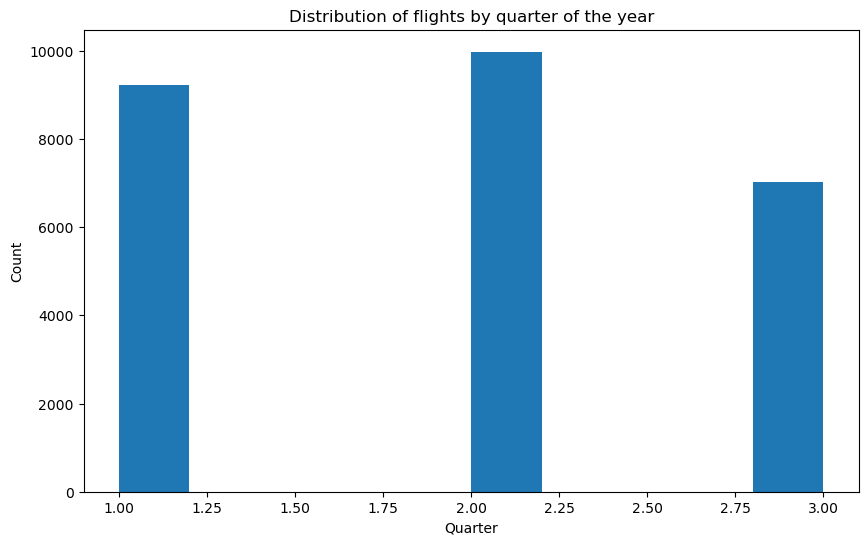

In [49]:
plot_histogram_of_column(flights["Q_YEAR"], "Distribution of flights by quarter of the year", "Quarter", None, False, False)

While the difference between the three quarters it is not huge, it is clear that, as we expected, the second quarter (i.e.: May to August) is the one with the greater amount of flights as it matches with the summer season.

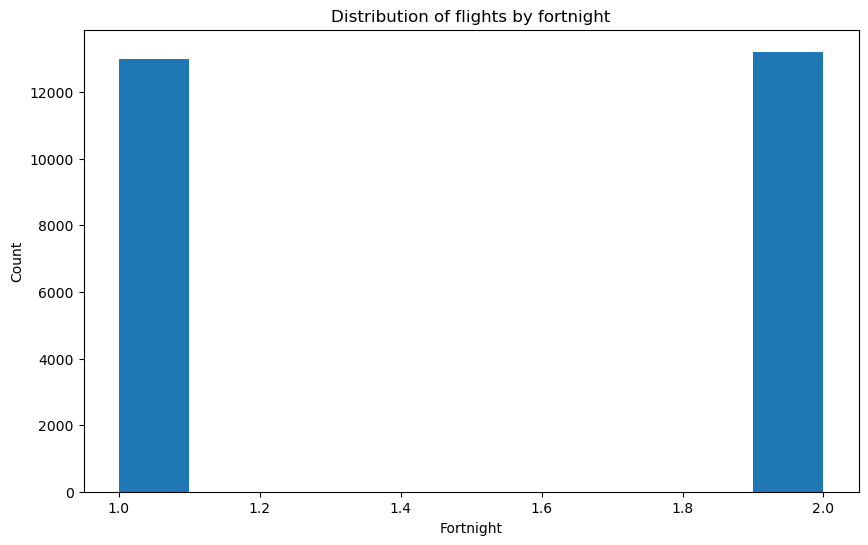

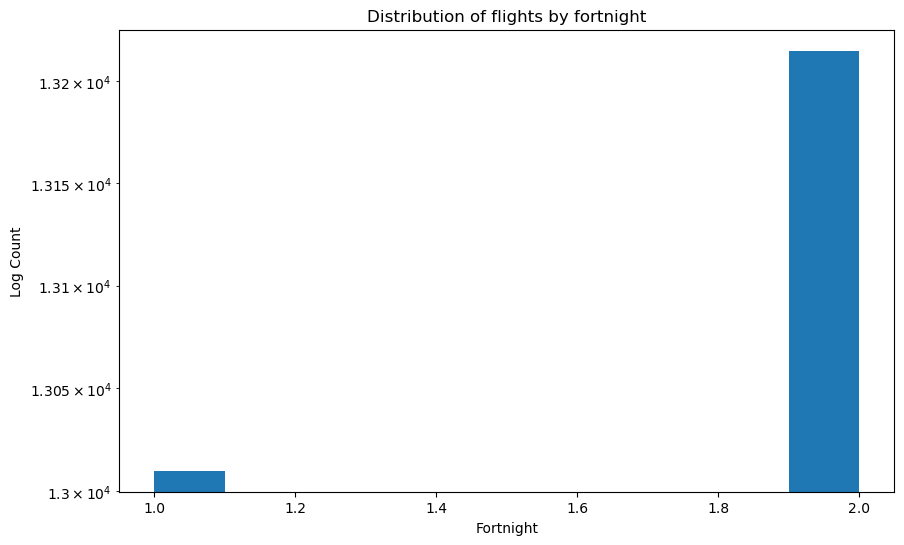

In [50]:
plot_histogram_of_column(flights["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, False)
plot_histogram_of_column(flights["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, True)

In this case, the difference is minimal. However, if we apply the logarithm to the y axis we can see that the second forntingh accumulates more flights than the first one.

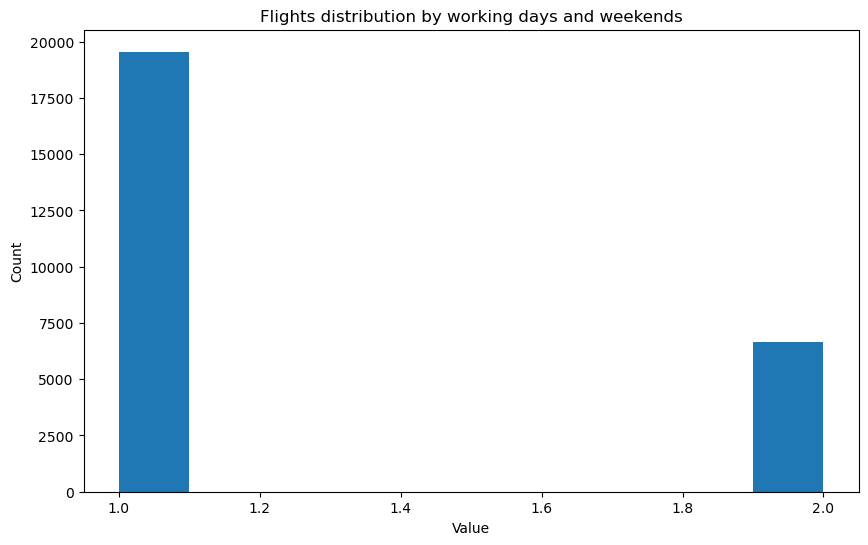

In [51]:
plot_histogram_of_column(flights["WEEK_INFO"], "Flights distribution by working days and weekends", None, None, False, False)

As it could be expected, weekdays accumulate almost three times more flights than weekends. However, we must keep in mind that the weekday category groups five days while the weekend only groups two days. Probably, the difference wouldn't be this big if we were plotting the average number of flights per day. However, this escapes from the scope of this project as it doesn't provide any additional information that could be helpful to predict flight delays.

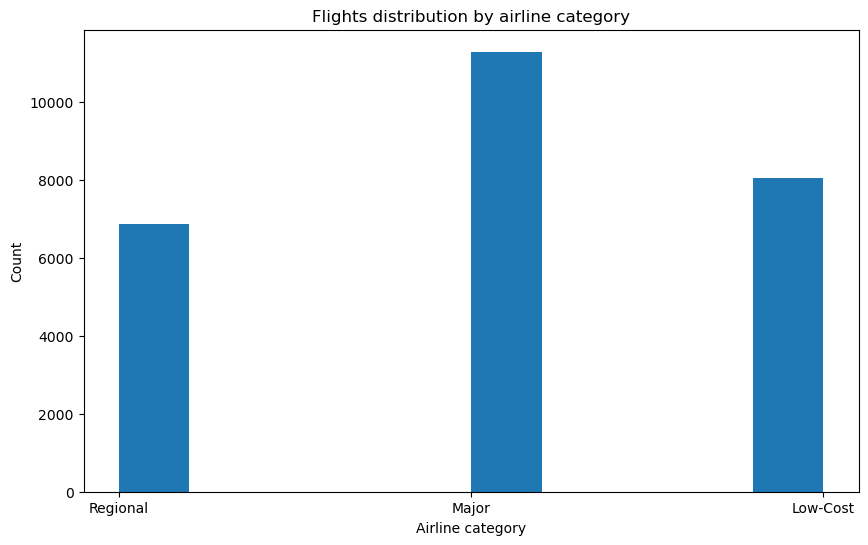

In [52]:
plot_histogram_of_column(flights["AC"], "Flights distribution by airline category", "Airline category", None, False, False)

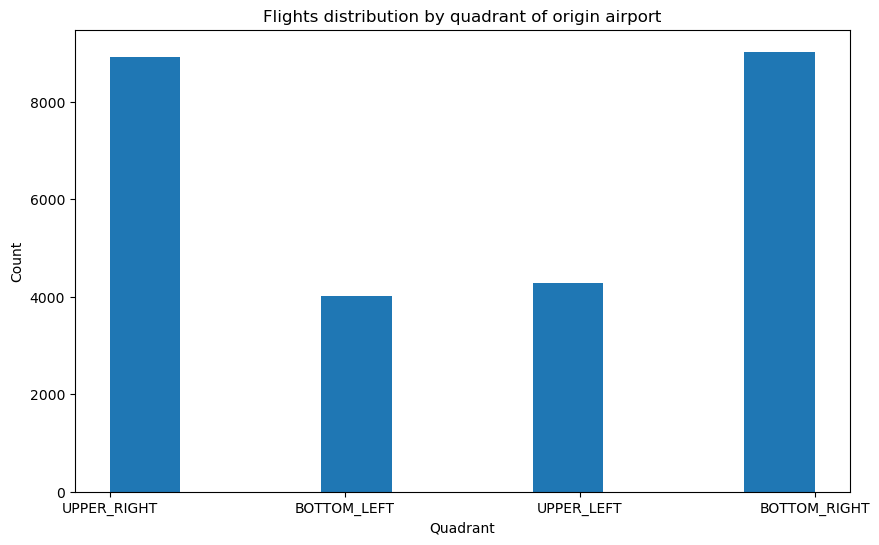

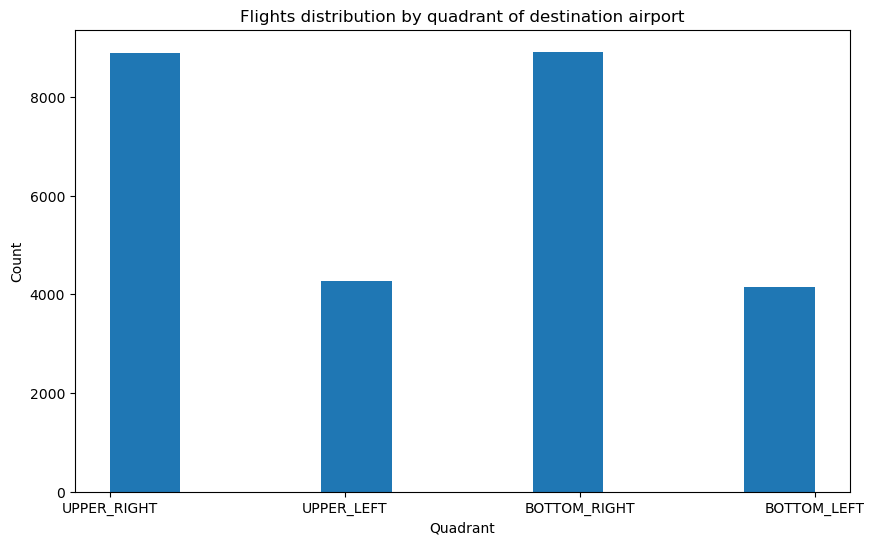

In [53]:
plot_histogram_of_column(flights["GR_O"], "Flights distribution by quadrant of origin airport", "Quadrant", None, False,False)

plot_histogram_of_column(flights["GR_D"], "Flights distribution by quadrant of destination airport", "Quadrant", None, False,False)

In both cases, the quadrants with the greater amount of flights are *UPPER_RIGHT* and *BOTTOM_RIGT*. This represents the east cost of the USA, where many of the biggest cities are located.

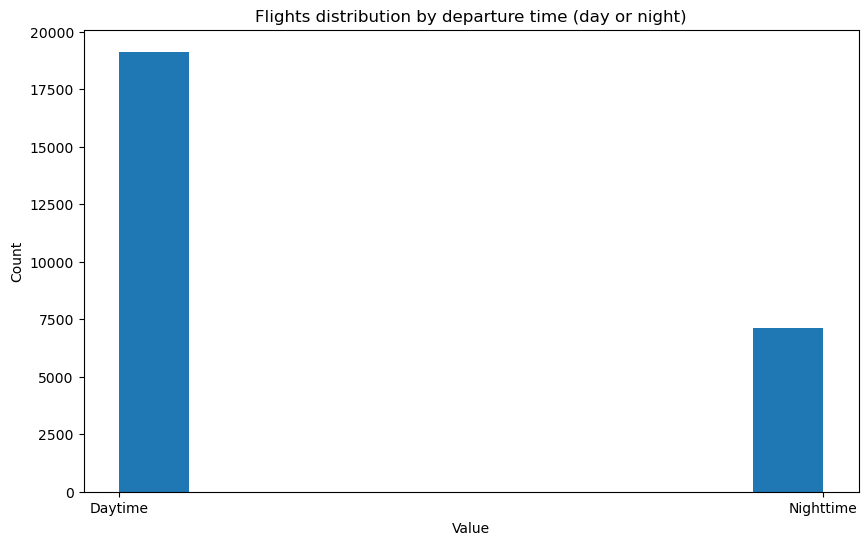

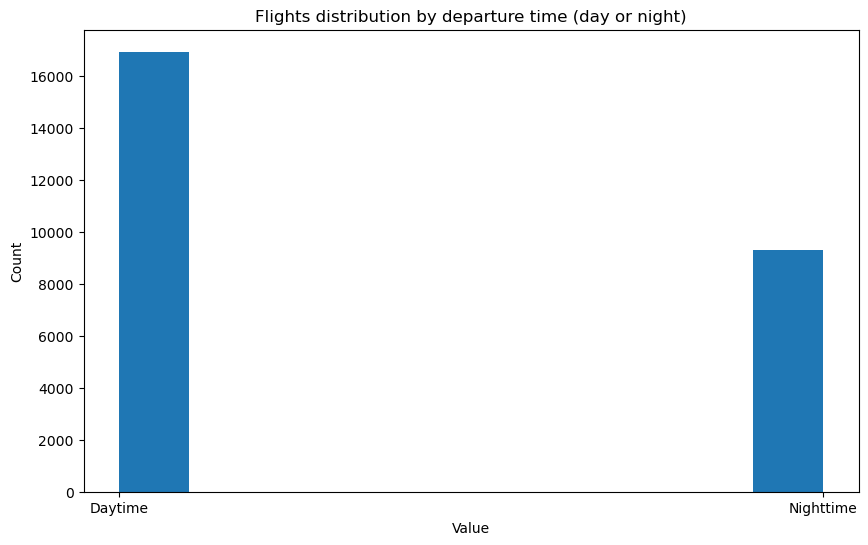

In [54]:
plot_histogram_of_column(flights["DepartureDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

plot_histogram_of_column(flights["ArrivalDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

Logically, most of the flights departure during daytime and this trend seems to hold for the arrival time. However, if we compare both histograms we will see that the amount of flights departing during daytime is considerably greater than the flights arriving during daytime. This mean that a considerable amount of flights arrive at their destination at night time even though day departed at daytime.

## Gauzanization of continuos variables

Since the models we will apply assume that our data is distributed following a gaussian distribution, we need to make sure that our data is gaussian.

First of all, we are going to determine which columns of our dataset are the ones containing continuous data

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>, <AxesSubplot: >]],
      dtype=object)

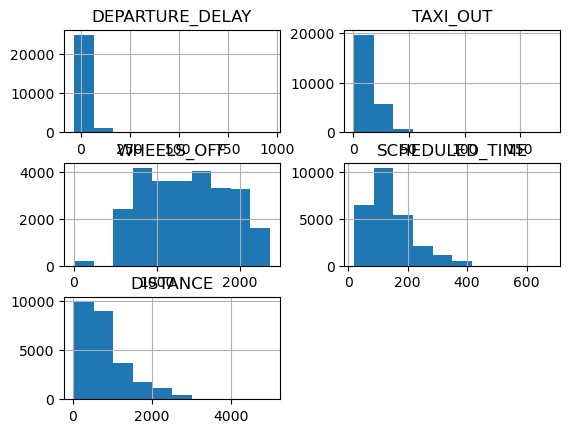

In [55]:
# Declare which variables are categorical and which ones are continuous. 

continuous = ['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE']

flights[continuous].hist()               

We see that our data doesn't follow a gaussian distribution. Before gaussianizing it, we will first remove any outliers that can be identified in the dataset.

In [56]:

def remove_outliers_zscore(data_series, threshold=3):
    """
    Remove outliers from a pandas Series using the Z-score method.
    :param data_series: a pandas Series containing the data
    :param threshold: the number of standard deviations from the mean at which to consider a data point an outlier
    :return: a new pandas Series with the outliers removed
    """
    z_scores = np.abs((data_series - data_series.mean()) / data_series.std())
    return data_series[z_scores <= threshold]


In [57]:

# Remove outliers 
flights_cont = remove_outliers_zscore(flights[continuous])
len(flights_cont)

26225

It can be seen that no outliers are removed. We can now proceed with the normalization of the continuous data defined before.

In [58]:
# we normalize continuous variables
from sklearn.preprocessing import QuantileTransformer

# Initialize transformer with number of quantiles and output distribution
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

# Apply transformation to continuous columns
for col in continuous:
    flights[col] = transformer.fit_transform(flights[col].values.reshape(-1, 1))

And we plot the normalized data, which now clearly follow a gaussian distribution.

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'WHEELS_OFF'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_TIME'}>],
       [<AxesSubplot: title={'center': 'DISTANCE'}>, <AxesSubplot: >]],
      dtype=object)

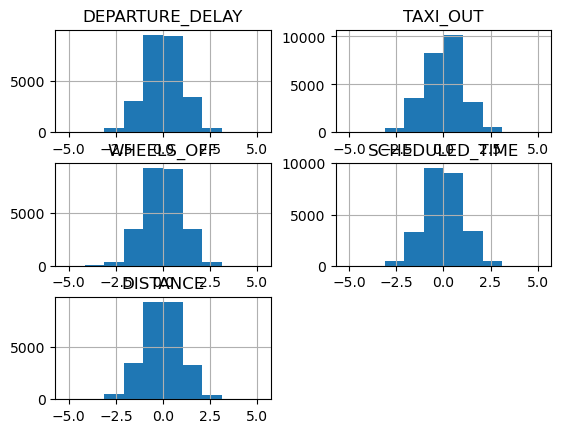

In [59]:
flights[continuous].hist()

## One hot encodign of categorical variables

After dealing with the continuous variables, we will apply hot encoding to our categorical variables, which are:
- Q_year
- Fortnight
- Week_info
- Ac
- Gr_o
- Gr_d
- ArrivalDayNight
- DepartureDayNight

In [60]:
# one hot encoding for categorical variables
categorical = ['Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']

flights= pd.get_dummies(flights, columns=categorical)

In [61]:
flights.columns

Index(['DELAYED', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR_1', 'Q_YEAR_2', 'Q_YEAR_3',
       'FORTNIGHT_1', 'FORTNIGHT_2', 'WEEK_INFO_1', 'WEEK_INFO_2',
       'AC_Low-Cost', 'AC_Major', 'AC_Regional', 'GR_O_BOTTOM_LEFT',
       'GR_O_BOTTOM_RIGHT', 'GR_O_UPPER_LEFT', 'GR_O_UPPER_RIGHT',
       'GR_D_BOTTOM_LEFT', 'GR_D_BOTTOM_RIGHT', 'GR_D_UPPER_LEFT',
       'GR_D_UPPER_RIGHT', 'ArrivalDayNight_Daytime',
       'ArrivalDayNight_Nighttime', 'DepartureDayNight_Daytime',
       'DepartureDayNight_Nighttime'],
      dtype='object')

## Initial modelling

Lastly, we will start testing some initial models and check what accuracy are we getting. First of all we need to split our variables into features (i.e.: X) and target variable (i.e.: y).

In [62]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target variable (y)

y = flights['DELAYED']
X = flights.drop('DELAYED', axis=1)

Now, we want to split our data into training and testing sets. The training set (*X_train* and *y_train*) are going to be used to traing the model using labelled data. Then, using only *X_test* we will make predictions and then check the accuracy of the results by comparing them to *y_test*

In [63]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

After splitting the data, we can initialize the model we will be using to predict flight delays. Then, using the fraction of the data we have selected for this purpouse, we will fit the model.

In [64]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train)

LogisticRegression()

Once the model has been trained, we are abla to make predictions based on the testing data. This will produce a one-dimentional vector containing 1's or 0's depending on if the model believes that flight is going to be delayed or not.

In [65]:
# Make predictions on the testing set
y_pred = logreg.predict(X_test)



Lastly, we will compute the accuracy of the model by comparing the predictions obtained from the model to real results from the testing data. 

In [66]:
from sklearn.metrics import accuracy_score

# Compute the accuracy of the model's predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.84


We get an 83% of accuracy, which is not bad at all specially when taking into account that only a small fraction of the available data has been used troughout the training and testing of the model.

## Linear classifiers

### Support Vector Machine (SVM)

In [67]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [68]:
y_pred = clf.predict(X_test)

In [69]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8425166825548142


### Naive Bayes

In [70]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB()
naive.fit(X_train,y_train)

GaussianNB()

In [71]:
y_pred = naive.predict(X_test)

In [72]:
accuracy_naive = accuracy_score(y_test, y_pred)
print(accuracy_naive)

0.78093422306959


### LDA

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [74]:
y_pred = lda.predict(X_test)

In [75]:
accuracy_lda = accuracy_score(y_test, y_pred)
print(accuracy_lda)

0.8375595805529076


### QDA

In [76]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7063870352716873


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Perceptron

In [77]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a Perceptron classifier
perceptron = Perceptron(eta0=0.1, max_iter=100, random_state=42)

# Train the Perceptron classifier
perceptron.fit(X_train, y_train)

# Make predictions on the test set
y_pred = perceptron.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.765490943755958


### Gradient boost

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()

# Train the classifier
gb_classifier.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = gb_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8625357483317445


### Random forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8560533841754051


### Neural Nets

In [85]:
from keras.models import Sequential
from keras.layers import Dense
# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the neural network model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

# Predict the target variable for the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.round(y_pred).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

Epoch 1/10


2023-05-15 21:51:33.265631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - 5s 5ms/step - loss: 0.4038 - accuracy: 0.8200
Epoch 2/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3462 - accuracy: 0.8546
Epoch 3/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3351 - accuracy: 0.8608
Epoch 4/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3286 - accuracy: 0.8616
Epoch 5/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3239 - accuracy: 0.8665
Epoch 6/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3208 - accuracy: 0.8670
Epoch 7/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3155 - accuracy: 0.8686
Epoch 8/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3128 - accuracy: 0.8701
Epoch 9/10
656/656 [==============================] - 3s 5ms/step - loss: 0.3087 - accuracy: 0.8715
Epoch 10/10
116/164 [====================>.........] - ETA: 0s

2023-05-15 21:52:07.971183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 0s 1ms/step
Accuracy: 0.8568160152526215


In [86]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Feature scaling using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the neural network model
model = Sequential()

# Add input layer and hidden layers with dropout regularization
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.3))  # Add dropout regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Add dropout regularization
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test),
          callbacks=[early_stopping], verbose=1)

# Predict the target variable for the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.round(y_pred).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Epoch 1/50


2023-05-15 21:54:28.454326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.6393

2023-05-15 21:54:32.431237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - 5s 6ms/step - loss: 0.6417 - accuracy: 0.6393 - val_loss: 0.5822 - val_accuracy: 0.6713
Epoch 2/50
656/656 [==============================] - 4s 6ms/step - loss: 0.5098 - accuracy: 0.7561 - val_loss: 0.4140 - val_accuracy: 0.8208
Epoch 3/50
656/656 [==============================] - 4s 6ms/step - loss: 0.4377 - accuracy: 0.8054 - val_loss: 0.3996 - val_accuracy: 0.8292
Epoch 4/50
656/656 [==============================] - 4s 6ms/step - loss: 0.4159 - accuracy: 0.8193 - val_loss: 0.3868 - val_accuracy: 0.8328
Epoch 5/50
656/656 [==============================] - 4s 6ms/step - loss: 0.4093 - accuracy: 0.8227 - val_loss: 0.3970 - val_accuracy: 0.8263
Epoch 6/50
656/656 [==============================] - 4s 6ms/step - loss: 0.4010 - accuracy: 0.8263 - val_loss: 0.3917 - val_accuracy: 0.8322
Epoch 7/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3966 - accuracy: 0.8276 - val_loss: 0.3854 - val_accuracy: 0.8315
Epoch 8/50
656/65

2023-05-15 21:56:18.777512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 0s 1ms/step
Accuracy: 0.8505243088655863
Precision: 0.8933153274814315
Recall: 0.6788096459722934
F1-score: 0.7714285714285715


In [88]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the neural network model
model = Sequential()

# Add input layer and hidden layers with dropout regularization
model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.4))  # Add dropout regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Add dropout regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Add dropout regularization

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test),
          callbacks=[early_stopping], verbose=1)

# Predict the target variable for the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.round(y_pred).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Epoch 1/50
  1/656 [..............................] - ETA: 3:05 - loss: 0.8831 - accuracy: 0.4062

2023-05-15 21:58:02.029024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - ETA: 0s - loss: 0.4491 - accuracy: 0.7921

2023-05-15 21:58:05.936467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


656/656 [==============================] - 5s 7ms/step - loss: 0.4491 - accuracy: 0.7921 - val_loss: 0.3643 - val_accuracy: 0.8389
Epoch 2/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3744 - accuracy: 0.8377 - val_loss: 0.3477 - val_accuracy: 0.8526
Epoch 3/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3569 - accuracy: 0.8497 - val_loss: 0.3390 - val_accuracy: 0.8582
Epoch 4/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3503 - accuracy: 0.8523 - val_loss: 0.3352 - val_accuracy: 0.8601
Epoch 5/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3432 - accuracy: 0.8551 - val_loss: 0.3309 - val_accuracy: 0.8612
Epoch 6/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3410 - accuracy: 0.8586 - val_loss: 0.3341 - val_accuracy: 0.8602
Epoch 7/50
656/656 [==============================] - 4s 6ms/step - loss: 0.3390 - accuracy: 0.8592 - val_loss: 0.3296 - val_accuracy: 0.8650
Epoch 8/50
656/65

2023-05-15 21:59:34.750785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 0s 1ms/step
Accuracy: 0.8657769304099142
Precision: 0.9013539651837524
Recall: 0.7172909184197024
F1-score: 0.7988571428571429
